In [13]:
from matching import get_matcher, available_models
from matching.viz import *
from pathlib import Path
import torch
import warnings
import torchvision.transforms as tfm

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
ransac_kwargs = {'ransac_reproj_thresh':3, 
                  'ransac_conf':0.95, 
                  'ransac_iters':2000} # optional ransac params
matcher = get_matcher(['superpoint-lg'], device=device, **ransac_kwargs) #try an ensemble!

Using device: cuda


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /home/nicholas/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 9.88MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /home/nicholas/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:08<00:00, 5.58MB/s]


### Look at images

(np.float64(-0.5), np.float64(999.5), np.float64(319.5), np.float64(-0.5))

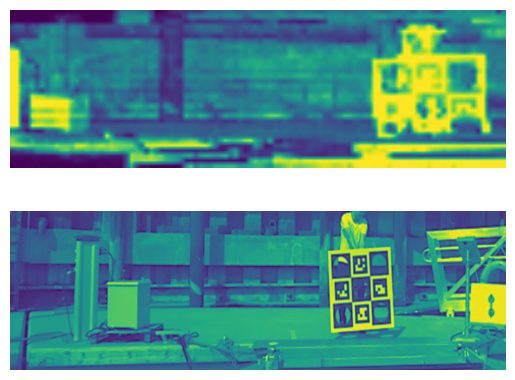

In [56]:
image_size = 512
# img0 = matcher.image_loader(pair[0], resize=image_size)
# img1 = matcher.image_loader(pair[1], resize=image_size)

IMAGES_FOLDER = "/home/nicholas/Downloads/delete"
image_lidar = plt.imread(f"{IMAGES_FOLDER}/lidar.png")[:,:,0]
image_rgb = plt.imread(f"{IMAGES_FOLDER}/image.png")[:,:,0]

img0 = tfm.ToTensor()(image_lidar[:, 500:600])
img1 = tfm.ToTensor()(image_rgb[500:700, 400:1200])

scale = 10
image_shape = (32*scale, 100*scale)
img0 = tfm.Resize(image_shape, antialias=True)(img0)
img1 = tfm.Resize(image_shape, antialias=True)(img1)

plt.figure("Images")
plt.subplot(2, 1, 1)
plt.imshow(tensor_to_image(img0))
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(tensor_to_image(img1))
plt.axis("off")

### See all matchers on the same image pair

Running model 1 of 5
Running model 2 of 5
Running model 3 of 5
Running model 4 of 5
Running model 5 of 5


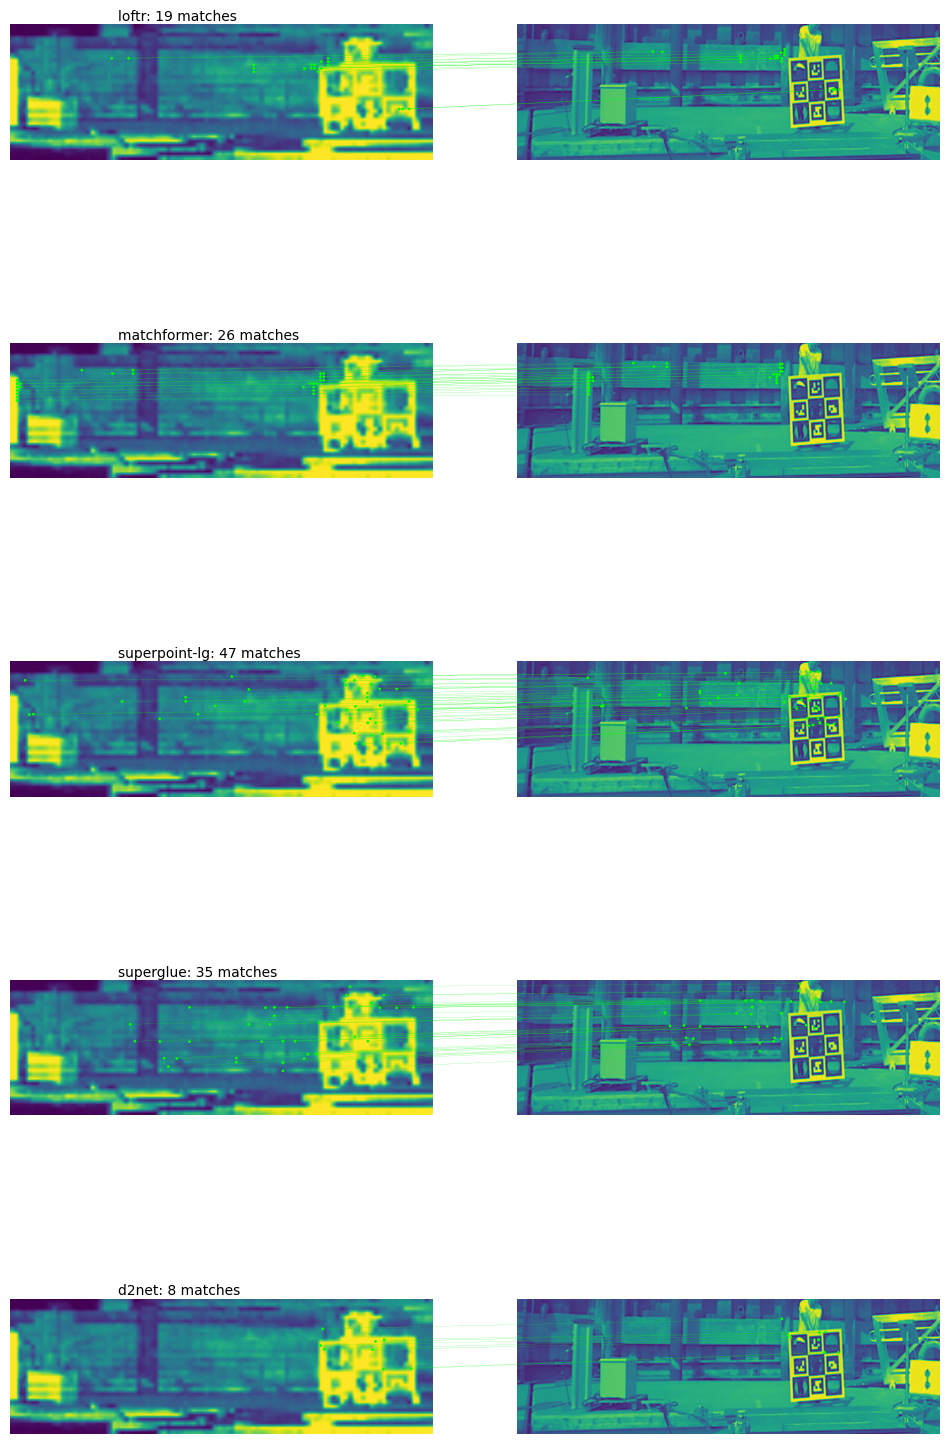

In [58]:
#%%capture

num_per_row = 1
# interesting_models = available_models
interesting_models = [
    "loftr",
    "matchformer",
    "superpoint-lg",
    "superglue",
    "d2net"
]

fig, axs = plt.subplots(int(np.ceil(len(interesting_models)/num_per_row)), 2*num_per_row, figsize=(12, 20))
flat_axs = axs.flatten()

for idx, model in enumerate(interesting_models):
    print(f"Running model {idx + 1} of {len(interesting_models)}")

    idx = idx * 2
    ax0, ax1 = flat_axs[idx], flat_axs[idx+1]

    try:
        matcher = get_matcher(model, device=device)
        result = matcher(img0, img1)
        num_inliers, H, mkpts0, mkpts1 = result['num_inliers'], result['H'], result['inlier_kpts0'], result['inlier_kpts1']

        ax0.imshow(tensor_to_image(img0))
        ax1.imshow(tensor_to_image(img1))
        _ = viz2d.plot_matches(mkpts0, mkpts1, color='lime', lw=0.1, ps=1, axes=[ax0, ax1])
        ax0.text(image_size/2, -10, f'{model}: {len(mkpts1)} matches')

    except Exception as e:
        blank_img = np.zeros_like(tensor_to_image(img0))
        ax0.imshow(blank_img)
        ax1.imshow(blank_img)
        ax0.text(image_size/2, -10, f'{model}: Error')
        print(f'Error with {model}: {e}')
    
for ax in flat_axs:
    ax.axis('off')